In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
moulayesididahi_masi_indice_dataset_path = kagglehub.dataset_download('moulayesididahi/masi-indice-dataset')

print('Data source import complete.')


100%|██████████| 531k/531k [00:00<00:00, 958kB/s]

Extracting files...
Data source import complete.


# Introduction
les différentes feuilles de calcul  représentent dans le contexte de la bourse marocaine, chaque feuille contienne des données relatives à son titre :

1. **Indices Généraux** :
   - Cette feuille pourrait contenir des données sur les principaux indices boursiers marocains, tels que le MASI (Moroccan All Shares Index), qui est un indice de toutes les valeurs cotées en continu.

2. **Avoirs officiels de réserve** :
   - Cela pourrait se référer aux réserves de change officielles du Maroc, qui sont des actifs étrangers détenus par la banque centrale et utilisés pour soutenir la politique monétaire, influençant ainsi la valeur de la monnaie nationale.

3. **CHANGE** :
   - Ici, on pourrait trouver des informations sur les taux de change de la monnaie marocaine, le Dirham, par rapport à d'autres devises. Les fluctuations de ces taux peuvent avoir un impact sur les entreprises marocaines impliquées dans l'import-export.

4. **MONIA** :
   - MONIA (Moroccan Overnight Index Average) est probablement un taux d'intérêt moyen pondéré pour les opérations de prêt interbancaire au Maroc. Cela reflète le coût du crédit sur le marché monétaire marocain.

5. **TMP** :
   - Cela pourrait signifier "Taux Moyen Pondéré" en français, qui peut être un taux d'intérêt de référence pour les prêts ou les obligations.

6. **Inflation** :
   - Ces données suivraient l'évolution du taux d'inflation au Maroc, ce qui est crucial pour évaluer la santé économique du pays et peut influencer la valeur des actions et la politique monétaire.

7. **Indices Taux** :
   - Cette feuille pourrait contenir des informations sur différents taux d'intérêt de référence, comme les taux des bons du Trésor, les taux hypothécaires, ou d'autres taux d'intérêt importants pour l'économie.

8. **Indices Sectorielles** :
   - Ces données fourniraient des informations sur les indices boursiers spécifiques à certains secteurs de l'économie marocaine, permettant de suivre la performance des secteurs comme l'agriculture, la finance, l'immobilier, etc.

Pour chaque feuille, les données pourraient inclure des valeurs historiques, des variations quotidiennes, mensuelles ou annuelles, et d'autres mesures pertinentes qui aident les investisseurs et les analystes à évaluer les tendances et à prendre des décisions informées. Pour une explication précise et détaillée, il serait nécessaire de voir les données exactes contenues dans chaque feuille.

# ETL-EDA  (Exploratory data analysis )

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
import os
# Chargement du fichier Excel
xls_file_path = os.path.join(moulayesididahi_masi_indice_dataset_path, 'MASI_indice_Dataset.xlsx')
xls = pd.ExcelFile(xls_file_path)
# Charger les données de l'indice MASI
indices_generaux_df = pd.read_excel(xls, sheet_name='Indices Généraux')
indices_generaux_df['SEANCE'] = pd.to_datetime(indices_generaux_df['SEANCE'])
# Charger les données indices sectectorielle
indices_sectorielles_df = pd.read_excel(xls, sheet_name='Indices Sectorielles')
indices_sectorielles_df['Étiquettes de lignes'] = pd.to_datetime(indices_sectorielles_df['Étiquettes de lignes'])
#Charger les données inflation
inflation_df = pd.read_excel(xls, sheet_name='Inlfation')
inflation_df['MOIS'] = pd.to_datetime(inflation_df['MOIS'])
# Charger les données des avoirs officiels de réserve
reserves_df = pd.read_excel(xls, sheet_name='Avoirs officiels de réserve')
# Convertir la colonne 'DATE' au format datetime
reserves_df['DATE'] = pd.to_datetime(reserves_df['DATE'])
# Charger les données indice taux
indices_taux_data = pd.read_excel(xls, sheet_name='Indices Taux')
# Convertir la colonne 'DATE' au format datetime
indices_taux_data['Étiquettes de lignes'] = pd.to_datetime(indices_taux_data['Étiquettes de lignes'])
indices_generaux_df.head()

,SEANCE,INDICE,COURS_CLOTURE,COURS_PLUS_HAUT,COURS_PLUS_BAS,COURS_OUVERTURE,COURS_VEILLE,VARIATION
0,2023-12-08,MASI,11885.32,11885.32,11824.97,11827.02,11827.02,0.49
1,2023-12-07,MASI,11827.02,11827.02,11757.60,11757.60,11757.60,0.59
2,2023-12-06,MASI,11757.60,11792.95,11718.07,11759.51,11759.51,-0.02
3,2023-12-05,MASI,11759.51,11785.10,11709.49,11728.06,11728.06,0.27
4,2023-12-04,MASI,11728.06,11769.43,11702.27,11748.19,11748.19,-0.17


In [ ]:
indices_generaux_df.info()

## analysis

In [6]:
#visualisation des tendances temporelles de l'indice MASI trimestrielle (quarter)

# Regroupement par trimestre et calcul de la moyenne pour la colonne 'COURS_CLOTURE'
indices_generaux_trimestriel = indices_generaux_df[['SEANCE', 'COURS_CLOTURE']].resample('Q', on='SEANCE').mean()

# Création du graphique Plotly
fig = px.line(indices_generaux_trimestriel, x=indices_generaux_trimestriel.index, y='COURS_CLOTURE',
              labels={'COURS_CLOTURE': 'Cours de Clôture Trimestriel Moyen', 'x': 'Trimestre'},
              title='Tendances Temporelles Trimestrielles du MASI')

# Personnalisation de l'arrière-plan
fig.update_layout({
    'plot_bgcolor': 'rgba(0, 0, 0, 0)',  # transparent
    'paper_bgcolor': 'rgba(10, 10, 10, 1)', # fond gris foncé
})

# Affichage du graphique
fig.show()

/tmp/ipython-input-3502060573.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  indices_generaux_trimestriel = indices_generaux_df[['SEANCE', 'COURS_CLOTURE']].resample('Q', on='SEANCE').mean()


In [7]:
#etudes de la volatilité de l'index MASI
# Sélection des colonnes 'SEANCE' et 'VARIATION'
indices_generaux_selected = indices_generaux_df[['SEANCE', 'VARIATION']]

# Regroupement par semaine et calcul de la moyenne hebdomadaire de la variation
indices_generaux_volatilite_hebdo = indices_generaux_selected.resample('W', on='SEANCE').mean()

# Création du graphique Plotly
fig_volatilite = px.line(indices_generaux_volatilite_hebdo, x=indices_generaux_volatilite_hebdo.index, y='VARIATION',
                        labels={'VARIATION': 'Variation Moyenne Hebdomadaire', 'x': 'Semaine'},
                         title='Volatilité Hebdomadaire du MASI')
fig_volatilite.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)', paper_bgcolor='rgba(200, 200, 200, 0.8)')
fig_volatilite.show()

Voici quelques observations que l'on peut tirer de ce graphique :

1. **Stabilité générale jusqu'à récemment :** Il semble que l'indice ait été relativement stable en termes de volatilité hebdomadaire pendant plusieurs années jusqu'à récemment.

2. **Augmentation récente de la volatilité :** Il y a une augmentation notable de la volatilité hebdomadaire autour de mai 2020 et jusqu'à récemment. Cela pourrait coïncider avec des événements économiques mondiaux, tels que la pandémie de COVID-19, qui ont eu un impact significatif sur les marchés financiers mondiaux.

3. **Spikes de volatilité :** Les pics de volatilité sont des moments où l'indice a connu des variations significatives sur une courte période. Ces pics pourraient être le résultat d'événements spécifiques ou de nouvelles qui affectent les perspectives économiques ou la confiance des investisseurs.

4. **Tendance à la baisse récente :** La série de valeurs négatives vers la fin du graphique suggère une tendance où les variations hebdomadaires étaient en moyenne négatives, ce qui pourrait indiquer une période de baisse ou de correction de l'indice.

5. **Analyse plus approfondie requise :** Pour une compréhension plus complète, une analyse plus approfondie pourrait être réalisée, en comparant la volatilité à d'autres indicateurs économiques ou événements de marché, ou en examinant des données de volatilité plus détaillées telles que l'écart-type.



In [8]:
 # calcul de L'écart type et autres stats
indices_generaux_df['VARIATION'].describe()

,VARIATION
count,2366.000000
mean,-0.001067
std,0.344325
min,-3.820000
25%,-0.004097
50%,0.000210
75%,0.004357
max,5.080000


In [10]:
# Comparaison des performances sectorielles
secteurs_selectionnes = ['AGROALIMENTAIRE & PRODUCTION', 'ASSURANCES', 'BANQUES', 'ELECTRICITE', 'TELECOMMUNICATIONS']

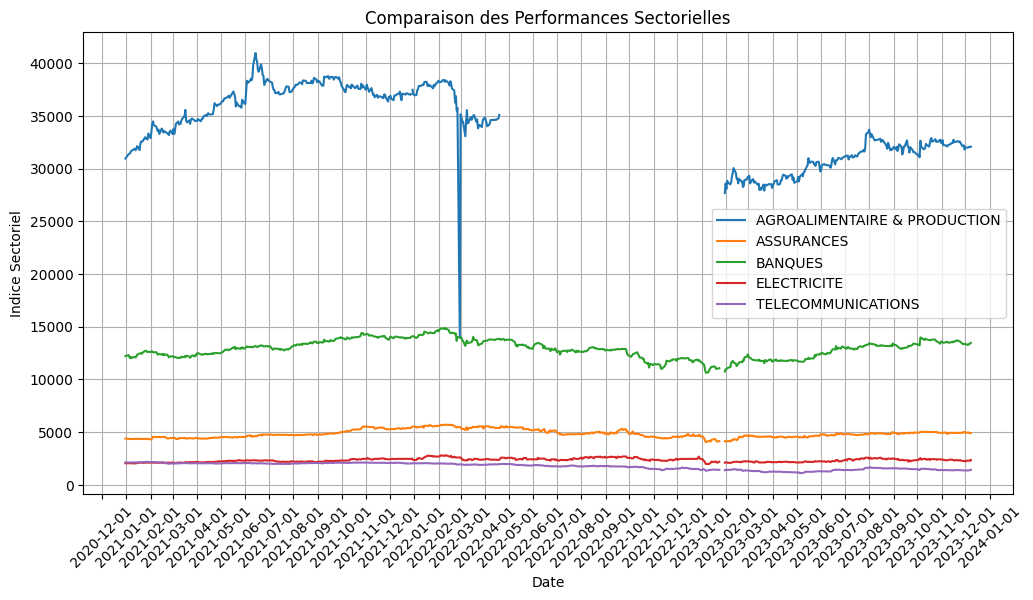

In [11]:
#visalutation Comparaison des performances sectorielles
plt.figure(figsize=(12, 6))
for secteur in secteurs_selectionnes:
    plt.plot(indices_sectorielles_df['Étiquettes de lignes'], indices_sectorielles_df[secteur], label=secteur)
plt.title('Comparaison des Performances Sectorielles')
plt.xlabel('Date')
plt.ylabel('Indice Sectoriel')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

Le graphique ci-dessus montre la performance de divers secteurs sur le marché boursier marocain. Il compare les indices d'agroalimentaire & production, d'assurances, de banques, d'électricité et des télécommunications.
Le graphique montre l'évolution des indices sectoriels pour cinq secteurs différents sur le marché boursier marocain. Voici une interprétation possible des tendances observées :

1. **Agroalimentaire & Production** :
   - C'est le secteur avec le niveau d'indice le plus élevé sur le graphique, indiquant potentiellement une forte performance relative à d'autres secteurs.
   - La ligne est relativement stable avec une tendance haussière sur la période considérée, suggérant une croissance constante ou une performance solide dans ce secteur.

2. **Assurances** :
   - Ce secteur a une performance inférieure à l'agroalimentaire mais suit une tendance similaire, avec une croissance modérée et constante sur la période.
   - Il montre une stabilité avec moins de volatilité que l'agroalimentaire, ce qui pourrait indiquer un risque moindre pour les investisseurs dans ce secteur.

3. **Banques** :
   - Le secteur bancaire montre un indice beaucoup plus bas, suggérant que sa performance est inférieure à celle des secteurs de l'agroalimentaire et des assurances.
   - La ligne est relativement plate avec une tendance légèrement négative, ce qui pourrait indiquer des défis ou une croissance faible dans le secteur bancaire.

4. **Électricité** :
   - Ce secteur montre la performance la plus basse parmi les secteurs analysés.
   - La ligne est plate, indiquant peu de changement dans l'indice sectoriel au fil du temps, ce qui pourrait suggérer peu de croissance ou des performances stables mais basses.

5. **Télécommunications** :
   - Le secteur des télécommunications présente une volatilité avec une tendance générale à la hausse.
   - Il existe un pic notable, qui pourrait représenter un événement spécifique ou une période de croissance exceptionnelle.

6. **Événement Anormal** :
   - Il y a un pic extrême visible dans le secteur de l'agroalimentaire & production. Cela pourrait être dû à une erreur de données, un ajustement d'indice, ou un événement de marché significatif.
   - Une telle anomalie mériterait une enquête plus approfondie pour comprendre sa cause.

En résumé, ce graphique suggère des performances variées à travers les secteurs, avec des tendances à long terme qui pourraient intéresser les investisseurs à la recherche de secteurs stables ou en croissance.

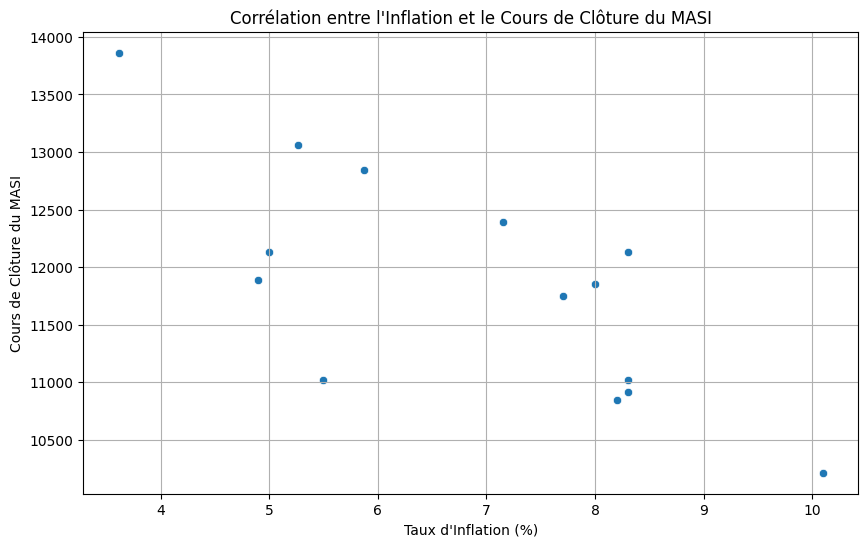

In [12]:
# Analyse de la corrélation avec l'inflation
merged_df = pd.merge(indices_generaux_df, inflation_df, left_on='SEANCE', right_on='MOIS', how='inner')
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='INFLATION', y='COURS_CLOTURE',markers='o')
plt.title('Corrélation entre l\'Inflation et le Cours de Clôture du MASI')
plt.xlabel('Taux d\'Inflation (%)')
plt.ylabel('Cours de Clôture du MASI')
plt.grid(True)
plt.show()

Le graphique de dispersion montre la relation entre le taux d'inflation et le cours de clôture de l'indice MASI

In [13]:
#Coefficient de corrélation de MASI avec linflation
correlation_coefficient = merged_df['INFLATION'].corr(merged_df['COURS_CLOTURE'])
print('Coefficient de corrélation :', correlation_coefficient)

Coefficient de corrélation : -0.7408660554077805


 Le coefficient de corrélation de -0.74 indique une corrélation négative modérément forte. Cela signifie que, dans cet ensemble de données, une augmentation de l'inflation est généralement associée à une baisse du cours de clôture de l'indice MASI.

### Les variations des réserves et impacte sur MASI

In [14]:
# Fusionner les données sur la base de la date avec les données de l'indice MASI
merged_df = pd.merge(indices_generaux_df, reserves_df, left_on='SEANCE', right_on='DATE', how='inner')

# Préparation de la visualisation avec Plotly
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Ajout de l'indice MASI au graphique
fig.add_trace(
    go.Scatter(x=merged_df['SEANCE'], y=merged_df['COURS_CLOTURE'], name='Cours de Clôture MASI'),
    secondary_y=False,
)
# Ajout des réserves de change au graphique (en utilisant la colonne appropriée pour les réserves)
fig.add_trace(
    go.Scatter(x=merged_df['DATE'], y=merged_df['AVOIRS_OFFICIELS_DE_RESERVE'], name='Avoirs Officiels de Réserve'),
    secondary_y=True,
)
# Mise à jour des titres des axes et du graphique
fig.update_layout(
    title_text="Impact des Avoirs Officiels de Réserve sur l'Indice MASI",
    xaxis_title="Date",
    yaxis_title="Indice MASI",
    paper_bgcolor='rgba(200, 200, 200, 1)',  # Fond gris
)
fig.update_yaxes(title_text="Avoirs Officiels de Réserve", secondary_y=True)
# Affichage du graphique
fig.show()


 une interprétation possible :

1. **Indice MASI** :
   - L'indice MASI semble avoir connu des fluctuations significatives au cours de la période présentée.
   - Après une période initiale de baisse, l'indice connaît une tendance à la hausse avec des périodes de volatilité.

2. **Avoirs Officiels de Réserve** :
   - Les avoirs officiels de réserve présentent également une tendance à la hausse, bien que moins régulière que celle de l'indice MASI. La série temporelle montre quelques périodes de variation rapide, qui pourraient correspondre à des interventions ou des changements de politique monétaire.

3. **Relation entre les deux séries** :
   - Il semble y avoir une relation entre les deux séries, avec des périodes où les tendances semblent se suivre.
   - Toutefois, sans une analyse statistique plus approfondie, il est difficile de tirer des conclusions définitives sur la nature et la force de cette relation. Un examen plus détaillé pourrait impliquer un calcul de corrélation ou une analyse de régression.

4. **Interprétation Contextuelle** :
   - Si les augmentations des réserves de change sont associées à des hausses de l'indice MASI, cela pourrait indiquer que les investisseurs interprètent les réserves croissantes comme un signe de stabilité économique, ce qui pourrait renforcer la confiance dans le marché boursier.
   - D'autre part, des augmentations soudaines et importantes des réserves pourraient refléter des flux de capitaux spécifiques ou des ventes d'actifs par le gouvernement, dont l'impact sur l'indice boursier pourrait varier selon le contexte.

5. **Anomalies et Points de Données** :
   - Des anomalies ou des pics particuliers dans l'une ou l'autre série pourraient coïncider avec des événements économiques, des annonces de politique monétaire ou des crises qui pourraient influencer à la fois les réserves et le marché boursier.


### Infuence des taux nominaux sur MASI

In [15]:
combined_data = pd.merge(indices_generaux_df, indices_taux_data, left_on='SEANCE', right_on='Étiquettes de lignes', how='inner')
selected_columns = ['SEANCE', 'COURS_CLOTURE', 'NOMINAL 1 AN', 'NOMINAL 5 ANS', 'NOMINAL 10 ANS']
plot_data = combined_data[selected_columns]
# Regroupement des données par trimestre et calcul des moyennes
plot_data_trimestrial = plot_data.resample('Q', on='SEANCE').mean()
# Création du graphique Plotly
fig = go.Figure()
# Cours de clôture de l'indice MASI
fig.add_trace(go.Scatter(x=plot_data_trimestrial.index, y=plot_data_trimestrial['COURS_CLOTURE'],
                         mode='lines', name='Cours Clôture MASI', line=dict(color='blue')))
# Taux d'intérêt nominaux
fig.add_trace(go.Scatter(x=plot_data_trimestrial.index, y=plot_data_trimestrial['NOMINAL 1 AN'],
                         mode='lines', name='Taux Nominal 1 An', line=dict(color='green')))
fig.add_trace(go.Scatter(x=plot_data_trimestrial.index, y=plot_data_trimestrial['NOMINAL 5 ANS'],
                         mode='lines', name='Taux Nominal 5 Ans', line=dict(color='red')))
fig.add_trace(go.Scatter(x=plot_data_trimestrial.index, y=plot_data_trimestrial['NOMINAL 10 ANS'],
                         mode='lines', name='Taux Nominal 10 Ans', line=dict(color='purple')))
# Mise à jour des titres et des axes
fig.update_layout(title='Comparaison Trimestrielle entre le Cours Clôture de l’indice MASI et les Taux Nominaux',
                  xaxis_title='Trimestre', yaxis_title='Valeurs Moyennes',
                  legend_title='Légende')

fig.show()

/tmp/ipython-input-3914459919.py:5: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



Le graphique ci-dessus montre la comparaison entre le cours de clôture de l’indice MASI et les taux nominaux à 1 an, 5 ans et 10 ans. Voici quelques observations que l'on peut faire :

- Le cours de clôture de l'indice MASI (en bleu) semble avoir sa propre tendance qui n'est pas toujours directement corrélée aux mouvements des taux d'intérêt.
- Les taux d'intérêt à 1 an, 5 ans, et 10 ans (en vert, rouge et violet respectivement) ont des tendances qui peuvent parfois se ressembler, mais elles ne sont pas nécessairement alignées avec la tendance de l'indice MASI.

Pour une analyse plus détaillée, nous pourrions examiner la corrélation entre ces variables ou effectuer une analyse plus approfondie sur des périodes spécifiques où des mouvements significatifs se produisent dans les deux séries de données. Cela pourrait nous aider à mieux comprendre l'impact des taux d'intérêt sur l'indice MASI.



1. **Gap de Trading**:
   - Un "gap" de trading se produit lorsque le cours d'ouverture est significativement différent du cours de clôture de la veille.
   - Les gaps peuvent être à la hausse ou à la baisse et sont souvent interprétés comme des signaux par les traders. Un gap à la hausse pourrait indiquer une forte demande, tandis qu'un gap à la baisse pourrait indiquer une pression à la vente.


In [16]:
# Calculons la différence entre le cours d'ouverture et le cours de clôture de la veille
indices_generaux_df['GAP'] = indices_generaux_df['COURS_OUVERTURE'] - indices_generaux_df['COURS_VEILLE']
# Visualisons maintenant ces gaps avec Plotly
fig_gap = px.line(indices_generaux_df, x='SEANCE', y='GAP', title='Gaps entre le Cours d\'Ouverture et le Cours de Veille du MASI')
# Personnalisation de l'arrière-plan du graphique
fig_gap.update_layout(
    plot_bgcolor='rgba(0, 0, 0, 0)',  # transparent pour le fond du graphique
    paper_bgcolor='rgba(200, 200, 200, 1)'  # gris pour le fond du papier
)
# Affichage du graphique
fig_gap.show()

In [17]:
# Fréquence des gaps non nuls
nombre_gaps_non_nuls = indices_generaux_df[indices_generaux_df['GAP'] != 0].shape[0]
# Magnitude moyenne des gaps (en valeur absolue pour prendre en compte les gaps positifs et négatifs)
magnitude_moyenne_gaps = indices_generaux_df['GAP'].abs().mean()
# Écart-type des gaps pour évaluer la dispersion des magnitudes de gap
ecart_type_gaps = indices_generaux_df['GAP'].std()
# Magnitude maximale des gaps (pour trouver les plus grands gaps positifs et négatifs)
magnitude_max_gap = indices_generaux_df['GAP'].abs().max()
print(f"Nombre de gaps de trading non nuls : {nombre_gaps_non_nuls}")
print(f"Magnitude moyenne des gaps de trading : {magnitude_moyenne_gaps}")
print(f"Écart-type des magnitudes de gap : {ecart_type_gaps}")
print(f"Magnitude maximale des gaps de trading : {magnitude_max_gap}")

Nombre de gaps de trading non nuls : 885
Magnitude moyenne des gaps de trading : 4.859465408521756
Écart-type des magnitudes de gap : 11.93277442794101
Magnitude maximale des gaps de trading : 119.05999999999949


# trading techniques

In [18]:
# Création du graphique en chandeliers pour l'indice MASI
masi_data=indices_generaux_df.copy()
fig = go.Figure(data=[go.Candlestick(x=masi_data['SEANCE'],
                open=masi_data['COURS_OUVERTURE'],
                high=masi_data['COURS_PLUS_HAUT'],
                low=masi_data['COURS_PLUS_BAS'],
                close=masi_data['COURS_CLOTURE'],
                name='MASI')])

fig.update_layout(
    title='Graphique Candlestick de l’indice MASI',
    xaxis_title='Date',
    yaxis_title='Cours',
    xaxis_rangeslider_visible=False,
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_x=0.5, # Centre le titre
    legend_title='Légende', # Ajoute un titre à la légende
    legend=dict(
        x=0.1, y=1.0, # Position de la légende
        bgcolor='rgba(255,255,255,0)',
        bordercolor='white'
    )
)


fig.update_xaxes(
    showline=True, linewidth=2, linecolor='white',
    gridcolor='grey', mirror=True,
    showgrid=True,
    tickfont=dict(color='white'),
)

fig.update_yaxes(
    showline=True, linewidth=2, linecolor='white',
    gridcolor='grey', mirror=True,
    showgrid=True,
    tickfont=dict(color='white'),
)

fig.show()

In [19]:
# Filtrage des données pour la période de janvier 2023 jusqu'à la dernière date disponible
start_date = '2023-01-01'
end_date = masi_data['SEANCE'].max()  # La dernière date disponible dans les données

# Création d'un nouveau DataFrame pour les données de 2023
masi_2023 = masi_data[(masi_data['SEANCE'] >= start_date) & (masi_data['SEANCE'] <= end_date)]
masi_2023=masi_2023.drop('INDICE',axis=1)
masi_2023.shape

(233, 8)

In [20]:
fig = go.Figure(data=[go.Candlestick(x=masi_2023['SEANCE'],
                open=masi_2023['COURS_OUVERTURE'],
                high=masi_2023['COURS_PLUS_HAUT'],
                low=masi_2023['COURS_PLUS_BAS'],
                close=masi_2023['COURS_CLOTURE'])])

fig.update_layout(
    title='Graphique Candlestick de l’indice MASI 2023',
    xaxis_title='Date',
    yaxis_title='Cours',
    xaxis_rangeslider_visible=False,
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    title_x=0.5,
    legend_title='Légende',
    legend=dict(
        x=0.1, y=1.0,
        bgcolor='rgba(255,255,255,0)',
        bordercolor='white'
    )
)

fig.show()


In [21]:
def renko_df(df, brick_size):
    """
    Generate Renko data from a DataFrame of historical prices.

    Parameters:
    df (DataFrame): A pandas DataFrame containing historical price data with at least 'SEANCE' and 'COURS_CLOTURE' columns.
    brick_size (float): The size of the Renko brick. This could be a fixed number or a dynamic value based on volatility or other metrics.

    Returns:
    DataFrame: A pandas DataFrame containing the Renko chart data which includes 'date' and 'close' columns representing the dates when a new Renko brick is formed and the price level of each brick respectively.

    Note: This function assumes that the input DataFrame 'df' is sorted in ascending order by date.
    """
    renko_data = {'date': [], 'close': []}
    current_price = df['COURS_CLOTURE'][0]
    for index, row in df.iterrows():
        while current_price + brick_size <= row['COURS_CLOTURE']:
            current_price += brick_size
            renko_data['date'].append(row['SEANCE'])
            renko_data['close'].append(current_price)
        while current_price - brick_size >= row['COURS_CLOTURE']:
            current_price -= brick_size
            renko_data['date'].append(row['SEANCE'])
            renko_data['close'].append(current_price)
    renko_df = pd.DataFrame(renko_data)
    return renko_df


In [22]:
# Calcul de l'Average True Range (ATR) pour la taille de la brique
high_low = masi_2023['COURS_PLUS_HAUT'] - masi_2023['COURS_PLUS_BAS']
high_close = np.abs(masi_2023['COURS_PLUS_HAUT'] - masi_2023['COURS_CLOTURE'].shift())
low_close = np.abs(masi_2023['COURS_PLUS_BAS'] - masi_2023['COURS_CLOTURE'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)
atr = true_range.rolling(14).mean()  # Période typique pour l'ATR est de 14  2 semaines

# Dernière valeur de l'ATR comme taille de la brique
brick_size = atr.iloc[-1]

In [23]:

renko_df = renko_df(masi_2023, brick_size)

In [24]:
fig = go.Figure()

# Ajouter les briques Renko au graphique
for index, row in renko_df.iterrows():
    fig.add_trace(go.Bar(x=[row['date']], y=[brick_size],
                         base=row['close']-brick_size,
                         width=86400000,  # Largeur en millisecondes pour la barre (1 jour)
                         showlegend=False))

# Mise à jour des titres et des axes
fig.update_layout(
    title='Graphique Renko de l’indice MASI 2023',
    xaxis_title='Date',
    yaxis_title='Cours',
    xaxis_rangeslider_visible=False,
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white')
)

# Affichage du graphique
fig.show()

### SLT

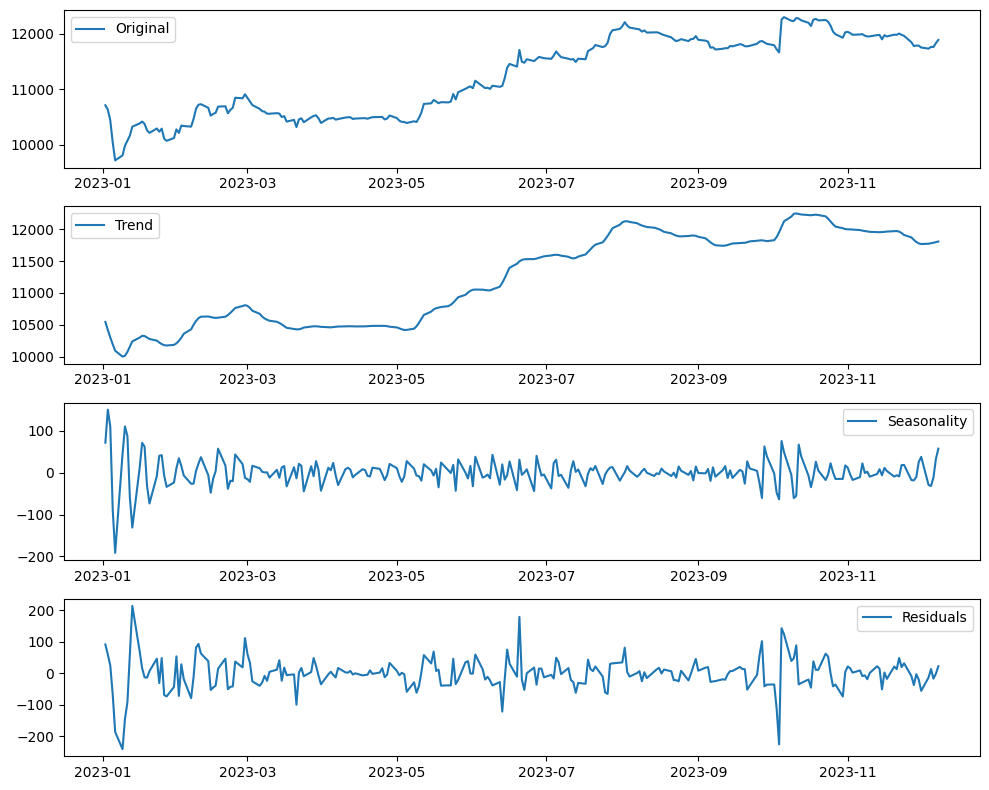

In [25]:
masi_2023.set_index('SEANCE', inplace=True)


masi_2023 = masi_2023.asfreq('B')  # 'B' pour les jours ouvrables*
masi_2023['COURS_CLOTURE'] = masi_2023['COURS_CLOTURE'].interpolate()

# Effectuer la décomposition STL
stl = STL(masi_2023['COURS_CLOTURE'], seasonal=7)  # 13 la saisonnalité attendue
result = stl.fit()

# Tracer les composantes
seasonal, trend, resid = result.seasonal, result.trend, result.resid

plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(masi_2023['COURS_CLOTURE'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Le graphique  montre la décomposition STL des données de l'indice MASI pour l'année 2023. Sur la base des graphiques, voici ce que nous pouvons interpréter :

1. **Série Originale** : Le premier graphique montre la série temporelle originale de l'indice MASI. Il donne une vue d'ensemble de la performance de l'indice sur l'année 2023.

2. **Tendance** : Le deuxième graphique montre la tendance dégagée par la série. Cela montre une tendance générale sans les fluctuations saisonnières ou les irrégularités.

3. **Saisonnalité** : Le troisième graphique qui devrait montrer la saisonnalité n'affiche pas de pattern saisonnier clair. Cela pourrait indiquer que la saisonnalité n'est pas un facteur important pour l'indice MASI sur cette période, ou que la période saisonnière spécifiée (7).

4. **Résidus** : Le quatrième graphique montre les résidus, qui représentent ce qui reste après avoir retiré la tendance et la saisonnalité de la série originale. Les résidus semblent être assez volatils, ce qui suggère que d'autres facteurs ou motifs non capturés par la tendance et la saisonnalité pourraient influencer les mouvements de l'indice.


**donc le resultat non conclusive**


### Test Dickey-Fuller

In [26]:
# Effectuer le test ADF sur la série temporelle des cours de clôture
adf_result = adfuller(masi_2023['COURS_CLOTURE'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interprétation du résultat
if adf_result[1] < 0.05:
    print("La série temporelle est probablement stationnaire.")
else:
    print("La série temporelle a probablement une racine unitaire et n'est pas stationnaire.")

ADF Statistic: -0.849806
p-value: 0.804053
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
La série temporelle a probablement une racine unitaire et n'est pas stationnaire.


### Differencing  (ducker-Fuller ajusté)

In [27]:

masi_2023_diff = masi_2023['COURS_CLOTURE'].diff().dropna()

# Ré-exécuter le test ADF sur la série temporelle différenciée
adf_result_diff = adfuller(masi_2023_diff)

print('ADF Statistic: %f' % adf_result_diff[0])
print('p-value: %f' % adf_result_diff[1])
print('Critical Values:')
for key, value in adf_result_diff[4].items():
    print('\t%s: %.3f' % (key, value))

# Interprétation du résultat après la différenciation
if adf_result_diff[1] < 0.05:
    print("La série temporelle différenciée est probablement stationnaire.")
else:
    print("La série temporelle différenciée a probablement encore une racine unitaire et n'est pas stationnaire.")

ADF Statistic: -13.462747
p-value: 0.000000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
La série temporelle différenciée est probablement stationnaire.


### ACF(AutoCorrelation) - PACF(Partial AutoCorrelation)

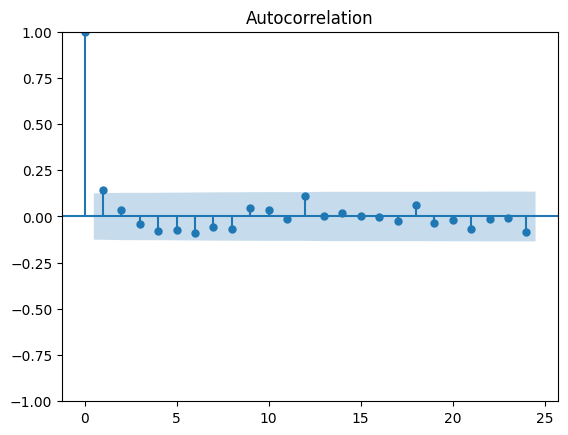

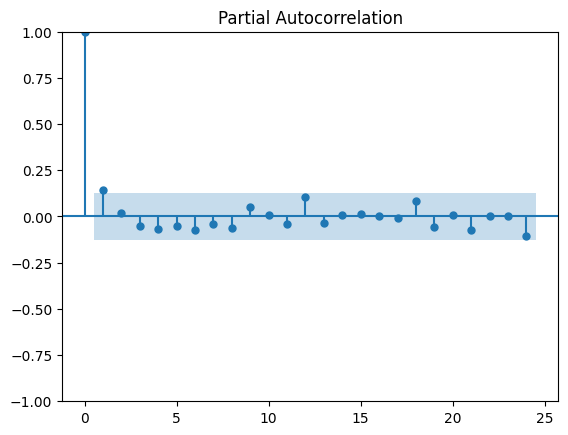

In [28]:
masi_2023_diff = masi_2023['COURS_CLOTURE'].diff().dropna()
# Tracer l'ACF
plot_acf(masi_2023_diff)
# Tracer la PACF
plot_pacf(masi_2023_diff)
plt.show()

Basé sur le graphique PACF, nous observons une forte corrélation partielle au premier décalage qui diminue rapidement au-delà de ce point. Ce comportement suggère un modèle autorégressif d'ordre 1, AR(1), pour le terme AR du modèle ARIMA. En d'autres termes, la valeur de pp pourrait être 1.

Le graphique ACF montre également une décroissance rapide après le premier décalage, ce qui est cohérent avec un processus autorégressif. Cela ne donne pas une indication claire d'un besoin de termes de moyenne mobile, car il n'y a pas de pics significatifs au-delà du décalage 0, donc qq pourrait être 0 ou 1, mais c'est moins certain.

### model ARIMA(1,1,0)

In [29]:
model1 = ARIMA(masi_2023_diff, order=(1,1,0))  #  (p, d, q) =(1,1,1) d=1 car une seule Differenciation
model1_fit = model1.fit()

# Affichage de l'AIC et du BIC
aic = model1_fit.aic
bic = model1_fit.bic

print(f"AIC: {aic}")
print(f"BIC: {bic}")

# Prévisions
forecast = model1_fit.forecast(steps=10)  # Prévoir les 10 prochaines périodes

print(forecast)

AIC: 2923.687788145503
BIC: 2930.673911032184
2023-12-11    63.236739
2023-12-12    61.045067
2023-12-13    62.018063
2023-12-14    61.586100
2023-12-15    61.777871
2023-12-18    61.692734
2023-12-19    61.730530
2023-12-20    61.713751
2023-12-21    61.721200
2023-12-22    61.717893
Freq: B, Name: predicted_mean, dtype: float64


### ARIMA(1,1,1)

In [30]:
model2 = ARIMA(masi_2023_diff, order=(1,1,1))  #  (p, d, q) =(1,1,1) d=1 car une seule Differenciation
model2_fit = model2.fit()

# Affichage de l'AIC et du BIC
aic = model2_fit.aic
bic = model2_fit.bic

print(f"AIC: {aic}")
print(f"BIC: {bic}")

# Prévisions
forecast2 = model2_fit.forecast(steps=10)  # Prévoir les 10 prochaines périodes

print(forecast2)

AIC: 2848.8989374051835
BIC: 2859.3781217352052
2023-12-11    12.680288
2023-12-12     5.956143
2023-12-13     4.965034
2023-12-14     4.818949
2023-12-15     4.797416
2023-12-18     4.794243
2023-12-19     4.793775
2023-12-20     4.793706
2023-12-21     4.793696
2023-12-22     4.793694
Freq: B, Name: predicted_mean, dtype: float64


> **NB :  MODEL THEORIQUE A INTENTION EDUCATIF. Moulaye.S.Dahi**